<img src="https://github.com/saraswathykrk/meat_data/blob/main/images.jpeg?raw=true" width="630" height="450" />

# TIME SERIES ANALYSIS

![Imgur](https://i.imgur.com/aooy8xP.gif)

## Table of contents
1. [Objective](#Objective)
2. [Data Loading and Visualization](#DataLoadingandVisualization)
3. [Decomposition](#Decomposition)
4. [Stationarity Check](#StationarityCheck)<br/>
    4.1. [Rolling Statistics Methodology](#RollingStatisticsMethodology)<br/>
    4.2. [ADF(Augmented Dickey-Fuller)Test](#ADF)   
5. [Data Transformation to achieve Stationarity](#DataTransformationtoachieveStationarity)<br/>
    5.1. [Log Scale Transformation](#LogScaleTransformation)<br/>
    5.2. [Log Scale - Moving Average Transformation](#LogScale-MovingAverageTransformation)<br/>
    5.3. [Exponential Decay Transformation](#ExponentialDecayTransformation)<br/>
    5.4. [Time Shift Transformation](#TimeShiftTransformation)<br/>
6. [Plotting ACF & PACF](#PlottingACF&PACF)
7. [Building Models](#BuildingModels)<br/>
    7.1. [AR Model](#ARModel)<br/>
    7.2. [ARMA Model](#ARMAModel)<br/>
    7.3. [ARIMA Model](#ARIMAModel)<br/>
8. [Using ARIMA for AR and MA ](#UsingARIMAforARandMA)


### 1. Objective <a name = "Objective"></a>
- Build a model to forecast the demand meat consumption
- The data is classified in years and the meat consumed per year, country wise, for the top 25 countries

### 2. Data Loading and Visualization <a name = "Data Loading and Visualization"></a>

__Import the dataset__ 

In [1]:
import pandas as pd  
dataset_final  =  pd.read_csv('https://raw.githubusercontent.com/saraswathykrk/meat_data/main/csv_files/top_25_meat_consumption.csv')
dataset_final.head()

,Entity,Code,Year,month,dates,Total_Meat_Consumption
0,Argentina,ARG,1961,January,January-1961,2.123959e+09
1,Argentina,ARG,1962,January,January-1962,2.179605e+09
2,Argentina,ARG,1963,January,January-1963,2.209499e+09
3,Argentina,ARG,1964,January,January-1964,1.812920e+09
4,Argentina,ARG,1965,January,January-1965,1.987530e+09


Time series deals with 2 columns,
- one is temporal i.e: __year__ in this case &
- another is the value to be forecasted ie: __total meat consumed__. <br/>


To make plotting graphs easier, we set __Year as the index__ of pandas dataframe as during plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis.

In [2]:
from datetime import datetime

dataset_final['dates']  =  pd.to_datetime(dataset_final['dates'],infer_datetime_format = True)             #convert from string to datetime

dataset1 = dataset_final

dataset = dataset_final.loc[dataset_final.Entity == "Brazil"].copy()
#dataset = dataset.drop(["Entity","Code",	"Year","month",	"Bovine_meat"	,"Poultry_meat","Pigmeat",	"Mutton_Goat",	"Meat_Other", "TOTAL_meat_consumed_per_capita",	"Total_population"], axis = 1)
dataset = dataset.drop(["Entity","Code",	"Year","month"], axis = 1)

dataset = dataset.sort_values(by=['dates'], ascending=True)
dataset = dataset[:-13]

In [3]:
indexedDataset  =  dataset.set_index(['dates'])
indexedDataset.head(5)

,Total_Meat_Consumption
dates,
1961-01-01,2.043552e+09
1962-01-01,2.102605e+09
1963-01-01,2.135536e+09
1964-01-01,2.214696e+09
1965-01-01,2.300289e+09


In [4]:
indexedDataset.tail(5)

,Total_Meat_Consumption
dates,
2013-01-01,1.961709e+10
2014-01-01,1.951401e+10
2015-01-01,2.001372e+10
2016-01-01,2.005141e+10
2017-01-01,2.075015e+10


__Visualizing the dataset__

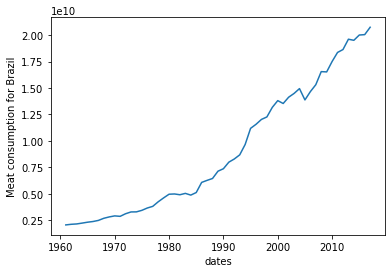

In [5]:
import matplotlib.pylab as plt 
%matplotlib inline                        

plt.xlabel('dates')
plt.ylabel('Meat consumption for Brazil')
plt.plot(indexedDataset)

From the plot below, we can see that there is a __Trend component__ in the series.<br/> Now for better clarity lets decompose the time series in its constituent components. 

### 3. Decomposition <a name = "Decomposition"></a>

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


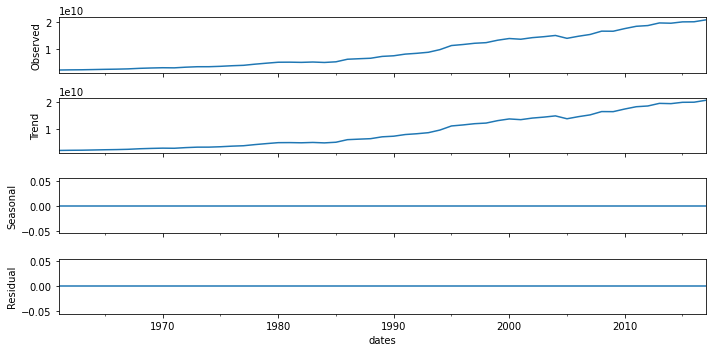

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']  =  10, 5

from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_dataset  =  seasonal_decompose(indexedDataset)         
figure  =  decomposed_dataset.plot()
plt.show()

### 4. Stationarity Check <a name = "Stationarity Check"></a>

We will see two methods two check stationarity. 

![Imgur](https://i.imgur.com/TOsgav1.jpg)

Making a function to check stationarity in one go using both __rolling statistics plot and ADF test__.

In [7]:
def test_stationarity(time_series):
    rolling_means(time_series)
    adf_test(time_series)

#### 4.1 Rolling Statistics Methodology <a name = "Rolling Statistics Methodology"></a>

In [8]:
# Determine rolling statistics
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 2).mean()    #window size 3 denotes 3 years, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 2).std()

    #Plot rolling statistics

    rcParams['figure.figsize']  =  10, 5 

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

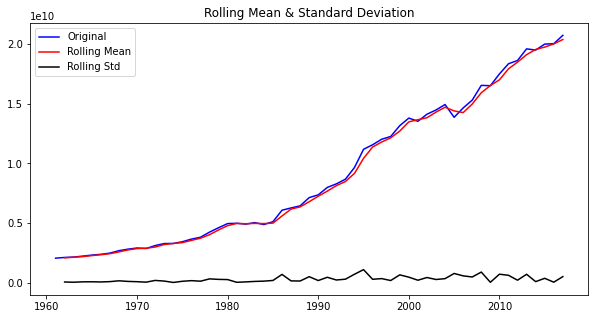

In [9]:
rolling_means(indexedDataset)

- Rolling mean has a __trend__ component 
- Rolling standard deviation is fairly __constant__ with time.

For our time series to be stationary, we need to ensure that both the __rolling statistics__ i.e: __mean & stdandard deviation remain time invariant__ or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so. 

To further augment our hypothesis that the time series is not stationary, let us perform the __ADCF test__.

#### 4.2  ADF(Augmented Dickey-Fuller) Test <a name = "ADF"></a>

For a Time series to be __stationary__, its ADF test should have:
1. __low p-value__ (according to the null hypothesis)
2. __Critical values__ at 1%, 5%, 10% confidence intervals should be as __close__ as possible __to__ the __Test Statistics__

In [10]:
#Perform Augmented Dickey–Fuller test:
def adf_test(time_series):
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series['Total_Meat_Consumption'], autolag = 'AIC')

    dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:')    
    print(dfoutput)

In [11]:
adf_test(indexedDataset)

Results of Dickey Fuller Test:
Test Statistic                  2.223558
p-value                         0.998901
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


- __large p-value__.
- Also critical values (1%, 5%, 10%) are __no where close to__ the Test Statistics.

Hence, we can safely say that **our Time Series at the moment is not stationary**

### 5. Data Transformation to achieve Stationarity <a name = "Data Transformation to achieve Stationarity"></a>

There are a couple of ways to achieve stationarity through data transformation like taking $log_{10}$,$log_{e}$, square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. 

#### 5.1 Log Scale Transformation  <a name = "Log Scale Transformation"></a>

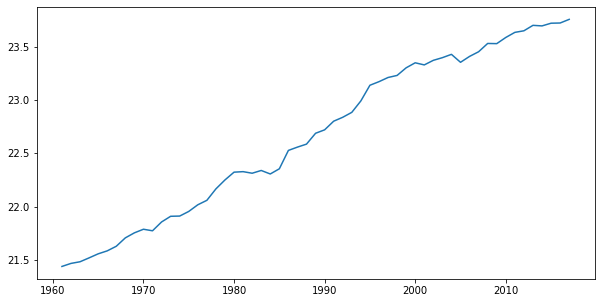

In [12]:
import numpy as np
indexedDataset_logScale  =  np.log(indexedDataset)
rcParams['figure.figsize']  =  10, 5
plt.plot(indexedDataset_logScale)

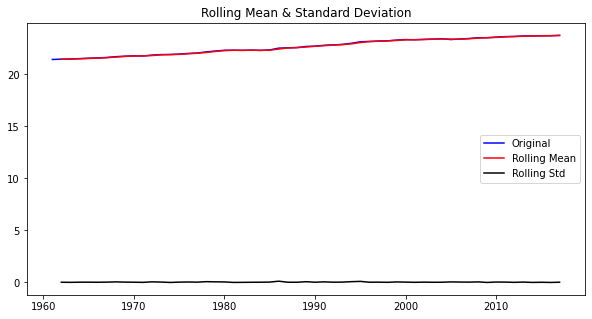

Results of Dickey Fuller Test:
Test Statistic                 -0.920829
p-value                         0.781036
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


In [13]:
test_stationarity(indexedDataset_logScale)

Still not stationary

From above graph, we see that even though rolling mean is __not stationary__, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:  

$log scale L  =  stationary part(L1) + trend(LT)$   
$moving avg of log scale A  =  stationary part(A1) + trend(AT)$   
$result series R  =  L - A  =  (L1+LT) - (A1+AT)  =  (L1-A1) + (LT-AT)$

Since, L & A are series & it moving avg, their trend will be more or less same, Hence  
LT-AT nearly equals to 0  

Thus trend component will be almost removed. And we have,  
  
$R  =  L1 - A1$, our final non-trend curve

#### 5.2 Log Scale - Moving Average Transformation  <a name = "Log Scale - Moving Average Transformation"></a>

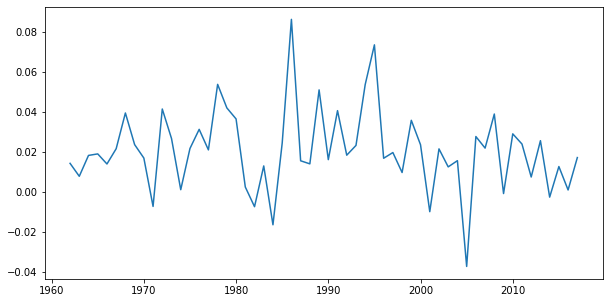

In [14]:
movingAverage  =  indexedDataset_logScale.rolling(window = 2).mean()
datasetLogScaleMinusMovingAverage  =  indexedDataset_logScale - movingAverage
plt.plot(datasetLogScaleMinusMovingAverage)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)


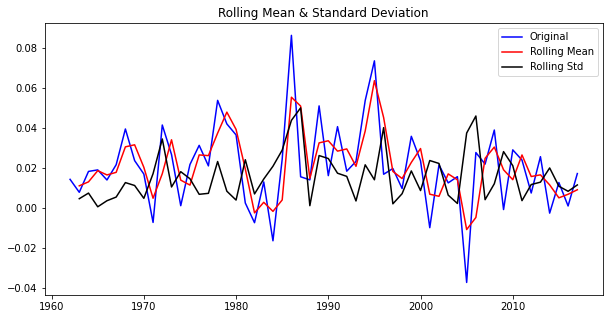

Results of Dickey Fuller Test:
Test Statistic                -6.737493e+00
p-value                        3.180121e-09
#Lags Used                     0.000000e+00
Number of Observations Used    5.500000e+01
Critical Value (1%)           -3.555273e+00
Critical Value (5%)           -2.915731e+00
Critical Value (10%)          -2.595670e+00
dtype: float64


In [15]:
test_stationarity(datasetLogScaleMinusMovingAverage)

- p-value has __reduced__ from 0.99 to 3.180121e-09.
- The __critical values__ at 1%,5%,10% confidence intervals are pretty __close to the Test Statistic__.

Thus, from above 2 points, we can say that our given series is stationary.  

From above graph, we observe that our intuition that *"subtracting two related series having similar trend components will make the result stationary"* is true.   



But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.  

### 5.3 Exponential Decay Transformation   <a name = "Exponential Decay Transformation "></a>

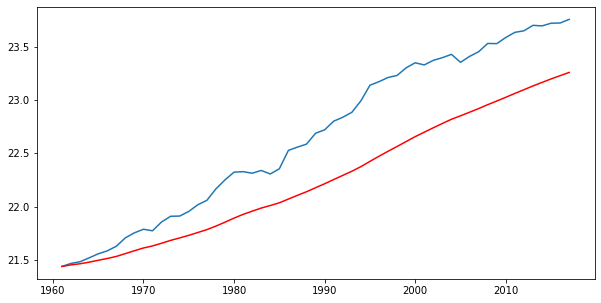

In [16]:
exponentialDecayWeightedAverage  =  indexedDataset_logScale.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color = 'red')

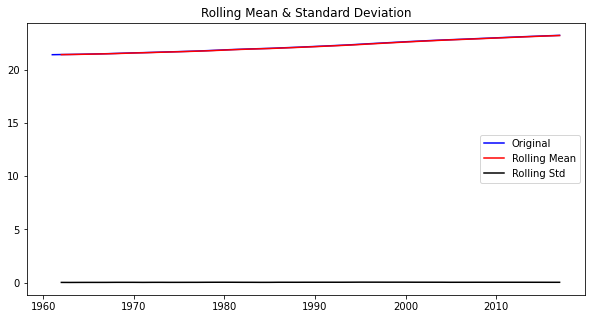

Results of Dickey Fuller Test:
Test Statistic                 -0.199568
p-value                         0.938573
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [17]:
test_stationarity(exponentialDecayWeightedAverage)

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar.

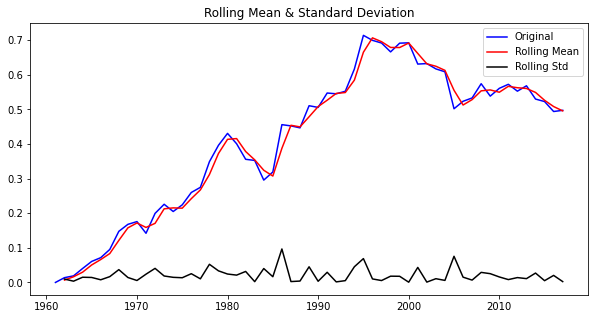

Results of Dickey Fuller Test:
Test Statistic                 -2.100426
p-value                         0.244343
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


In [18]:
datasetLogScaleMinusExponentialMovingAverage  =  indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.  
Also,     
1. p-value has __decreased__ from 0.938573 to 0.244.  
2. Test Statistic value is very __much closer__ to the Critical values.  


Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.

But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:  

Given a set of observation on the time series:  
$ x0, x1, x2, x3, .... xn $  

The shifted values will be:    
$ null, x0, x1, x2,.... xn $                             <---- basically all xi's shifted by 1 pos to right  

Thus, the time series with time shifted values are:   
$ null, (x1-x0), (x2-x1), (x3-x2), (x4-x3),.... (xn-x_{n-1}) $   

### 5.4 Time Shift Transformation  <a name = "Time Shift Transformation"></a>

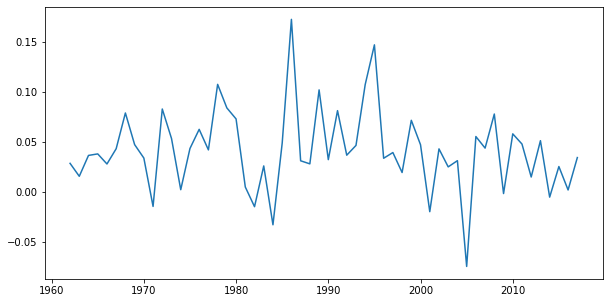

In [19]:
datasetLogDiffShifting  =  indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

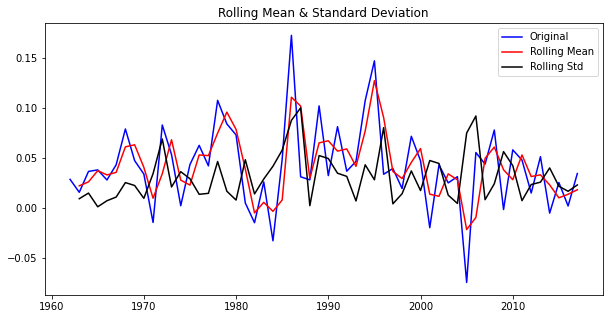

Results of Dickey Fuller Test:
Test Statistic                -6.737493e+00
p-value                        3.180121e-09
#Lags Used                     0.000000e+00
Number of Observations Used    5.500000e+01
Critical Value (1%)           -3.555273e+00
Critical Value (5%)           -2.915731e+00
Critical Value (10%)          -2.595670e+00
dtype: float64


In [20]:
datasetLogDiffShifting.dropna(inplace = True)

test_stationarity(datasetLogDiffShifting)


From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:
1. p-value is 3.180121e-09.  
2. Test Statistic value not as close to the critical values as that for exponential decay.  
  
We have thus tried out 3 different transformation: log, exp decay & time shift. We will go ahead with the __timeshifted dataset.__ 

### 6. Plotting ACF & PACF <a name = "Plotting ACF & PACF"></a>

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


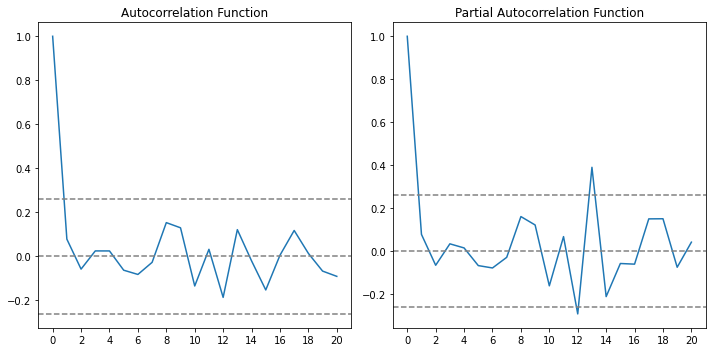

In [21]:
#ACF & PACF plots

from statsmodels.tsa.stattools import acf, pacf

lag_acf  =  acf(datasetLogDiffShifting, nlags = 20)
lag_pacf  =  pacf(datasetLogDiffShifting, nlags = 20, method = 'ols')
rcParams['figure.figsize']  =  10, 5
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,22,2))
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,22,2))
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the __ACF graph__, 
- Curve touches y = 0.0 line at x = 2. Thus, __Q  =  2__


From the __PACF graph__,
- Curve touches y = 0.0 line at x = 2. Thus, __P  =  2__

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

### 7. Building Models <a name = "Building Models"></a>

Let us forecaste deploying AR, ARMA and ARIMA model.

#### 7.1 AR Model <a name = "AR Model"></a>

- Using AR model to forecast the Total_Meat_Consumption for __7 years__. 
- Dividing the dataset into __train and test__. Keeping last 7 years data for testing the performance of our time series model.

In [22]:
datasetLogDiffShifting.head()

,Total_Meat_Consumption
dates,
1962-01-01,0.028487
1963-01-01,0.015541
1964-01-01,0.036397
1965-01-01,0.037920
1966-01-01,0.027844


In [23]:
# Data Preparation
train, test = datasetLogDiffShifting[1:len(datasetLogDiffShifting)-7], datasetLogDiffShifting[len(datasetLogDiffShifting)-7:]
train.head()

,Total_Meat_Consumption
dates,
1963-01-01,0.015541
1964-01-01,0.036397
1965-01-01,0.037920
1966-01-01,0.027844
1967-01-01,0.043101


In [24]:
test

,Total_Meat_Consumption
dates,
2011-01-01,0.047753
2012-01-01,0.014829
2013-01-01,0.051128
2014-01-01,-0.005269
2015-01-01,0.025285
2016-01-01,0.001882
2017-01-01,0.034254


- Deploying the autoregression model of __statsmodels library__ provided in the ar_model class.
- It automatically selects an appropriate lag value using statistical tests and trains a linear regression model.

In [25]:
from statsmodels.tsa.ar_model import AR
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 10
Coefficients: const                         0.053967
L1.Total_Meat_Consumption     0.108249
L2.Total_Meat_Consumption    -0.058794
L3.Total_Meat_Consumption     0.023878
L4.Total_Meat_Consumption     0.018003
L5.Total_Meat_Consumption    -0.140086
L6.Total_Meat_Consumption    -0.030241
L7.Total_Meat_Consumption    -0.134786
L8.Total_Meat_Consumption     0.197812
L9.Total_Meat_Consumption     0.035181
L10.Total_Meat_Consumption   -0.193835
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


- Observe that a __13-lag model__ was chosen and trained. This is interesting given how close this lag is to the number of months in a year.

- __Forecasting__ using the developed model and printing out the __7 year forecast__.

In [26]:
# make predictions
print(len(train),len(test))
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions.head()
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test.iloc[i]))


48 7
predicted=0.063577, expected=0.047753
predicted=0.059772, expected=0.014829
predicted=0.019913, expected=0.051128
predicted=0.049435, expected=-0.005269
predicted=0.067208, expected=0.025285
predicted=0.055663, expected=0.001882
predicted=0.033404, expected=0.034254


- __Model evaluation__ using Mean_squared_error

Test MSE: 0.002
            Total_Meat_Consumption
dates                             
2011-01-01                0.047753
2012-01-01                0.014829
2013-01-01                0.051128
2014-01-01               -0.005269
2015-01-01                0.025285
2016-01-01                0.001882
2017-01-01                0.034254


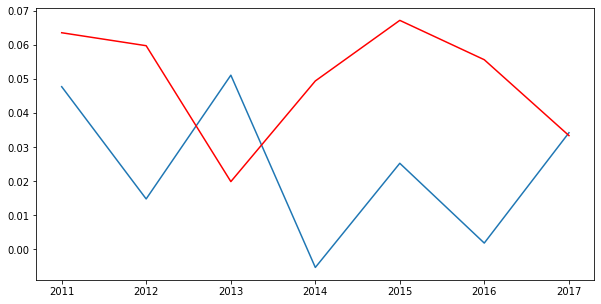

In [27]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
print(test)

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Observing the plot of <span style="color:blue">**__expected__** </span> vs the <span style="color:red">**__predicted__** </span>.

The forecast does look pretty good with slightly large deviation on year 4.

Plotting AR model


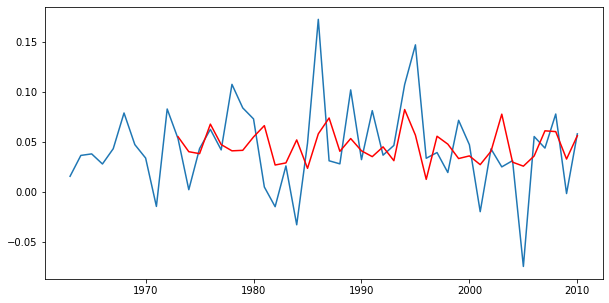

In [28]:
plt.plot(train)
plt.plot(model_fit.fittedvalues, color = 'red')
print('Plotting AR model')

#### 7.2 ARMA Model <a name = "ARMA Model"></a>

In [29]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train,order=(2,0,2))
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 2
Coefficients: const                           0.044275
ar.L1.Total_Meat_Consumption    0.070648
ar.L2.Total_Meat_Consumption   -0.100680
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


- Observe that a __2-lag model__ was chosen and trained. 

- __Forecasting__ using the developed model and printing out the __7 year forecast__.

In [30]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test.iloc[i]))

predicted=0.049868, expected=0.047753
predicted=0.043295, expected=0.014829
predicted=0.043643, expected=0.051128
predicted=0.044329, expected=-0.005269
predicted=0.044343, expected=0.025285
predicted=0.044275, expected=0.001882
predicted=0.044269, expected=0.034254


- __Model evaluation__ using Mean_squared_error

Test MSE: 0.001


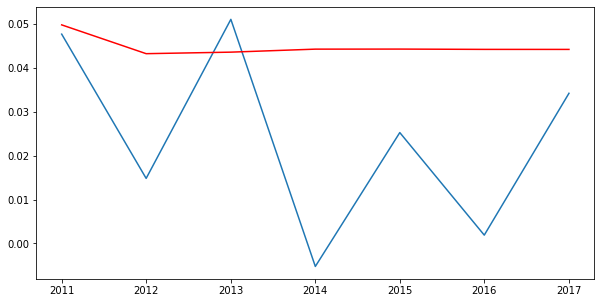

In [31]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

MSE is more than that obtained with AR model. <br/>
Observing the plot of <span style="color:blue">**__expected__** </span> vs the <span style="color:red">**__predicted__** </span>.
The forecast doesnt look good with large deviation at 3 and 5.

Plotting ARMA model


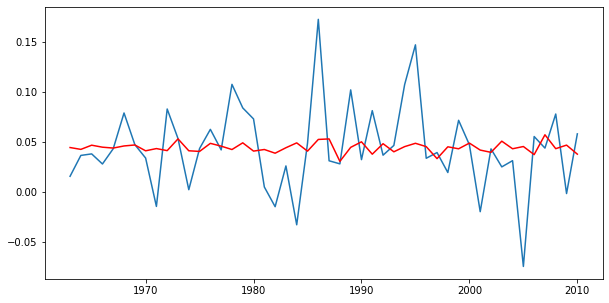

In [32]:
plt.plot(train)
plt.plot(model_fit.fittedvalues, color = 'red')
print('Plotting ARMA model')

- Alternatively you can also use __plot_predict()__ method. 

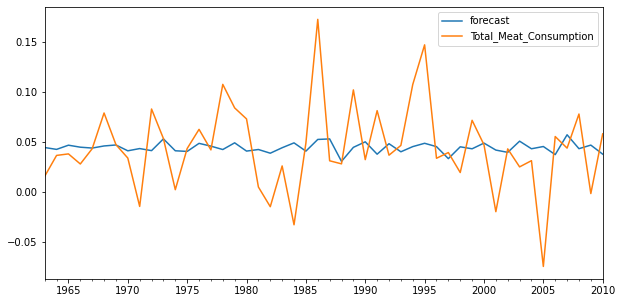

In [33]:
plot = model_fit.plot_predict()

#### 7.3 ARIMA Model <a name = "ARIMA Model"></a>

- Training ARIMA model with __stationary__ made dataset "datasetLogDiffShifting" using the (p,d,q) = __(2,0,2)__. 
- p and q values are chosen considering observations of ACF and PACF plots.

In [34]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(datasetLogDiffShifting,order=(2,0,1))
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 2
Coefficients: const                           0.044275
ar.L1.Total_Meat_Consumption    0.070648
ar.L2.Total_Meat_Consumption   -0.100680
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


- Observe that a __2-lag model__ was chosen and trained. 

- __Model evaluation__ using Mean_squared_error

In [35]:
results_ARIMA = model.fit()

In [36]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(datasetLogDiffShifting, results_ARIMA.fittedvalues)
print('Test MSE: %.3f' % error)

Test MSE: 0.002


In [37]:
results_ARIMA.fittedvalues.head()

dates
1962-01-01    0.041443
1963-01-01    0.040452
1964-01-01    0.040184
1965-01-01    0.042561
1966-01-01    0.041120
dtype: float64

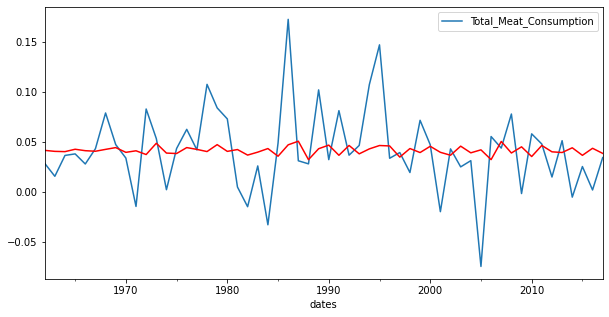

In [38]:
datasetLogDiffShifting.plot()
results_ARIMA.fittedvalues.plot(color='red')

- Alternatively you can also use __plot_predict()__ method. 

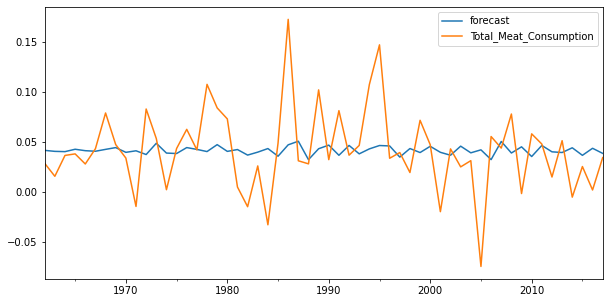

In [39]:
fitted_values = results_ARIMA.plot_predict()

### Prediction & Reverse transformations of fittedvalues 

In [40]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

dates
1962-01-01    0.041443
1963-01-01    0.040452
1964-01-01    0.040184
1965-01-01    0.042561
1966-01-01    0.041120
dtype: float64

In [41]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

dates
1962-01-01    0.041443
1963-01-01    0.081895
1964-01-01    0.122079
1965-01-01    0.164640
1966-01-01    0.205760
dtype: float64

In [42]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Total_Meat_Consumption'].iloc[0], index=datasetLogDiffShifting.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

dates
1962-01-01    21.479399
1963-01-01    21.519850
1964-01-01    21.560035
1965-01-01    21.602595
1966-01-01    21.643715
dtype: float64

In [43]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction.head()

,0
dates,
1962-01-01,2.130023e+09
1963-01-01,2.217952e+09
1964-01-01,2.308894e+09
1965-01-01,2.409284e+09
1966-01-01,2.510418e+09


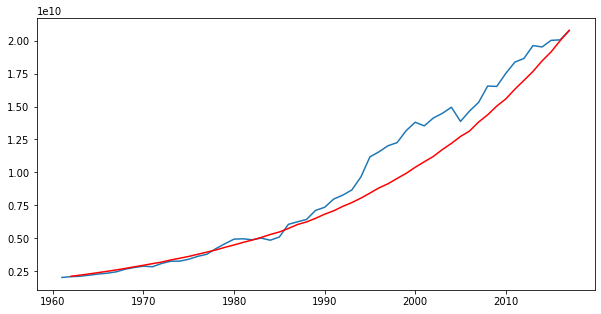

In [44]:
from matplotlib import pyplot
pyplot.plot(indexedDataset)
pyplot.plot(reverted_back_prediction, color='red')
pyplot.show()

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

In [45]:
indexedDataset_logScale.columns = ['Total_Meat_Consumption in logscale']
reverted_back_prediction.columns = ['ARIMA Predicted Total_Meat_Consumption']
datasetLogDiffShifting.columns = ['Total_Meat_Consumption after log diff shifting']

In [46]:
df = pd.concat([indexedDataset,indexedDataset_logScale, datasetLogDiffShifting,reverted_back_prediction], axis=1, sort=False)
df.tail()

,Total_Meat_Consumption,Total_Meat_Consumption in logscale,Total_Meat_Consumption after log diff shifting,ARIMA Predicted Total_Meat_Consumption
dates,,,,
2013-01-01,1.961709e+10,23.699667,0.051128,1.765708e+10
2014-01-01,1.951401e+10,23.694398,-0.005269,1.845186e+10
2015-01-01,2.001372e+10,23.719684,0.025285,1.913766e+10
2016-01-01,2.005141e+10,23.721566,0.001882,1.998902e+10
2017-01-01,2.075015e+10,23.755819,0.034254,2.077220e+10


### Forecasting the Total_Meat_Consumption for the next 13 years

- We have 57(existing data of 57 yrs) data points. <br/>
To forecast additional 13 data points or __13 yrs__.
- Using plot_predict method

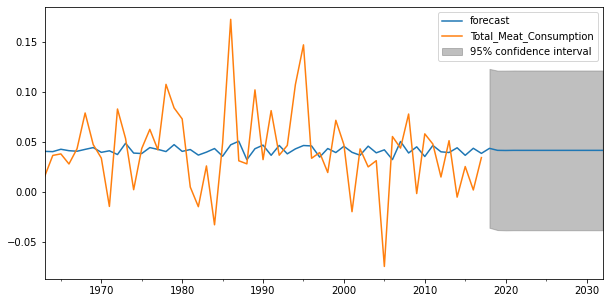

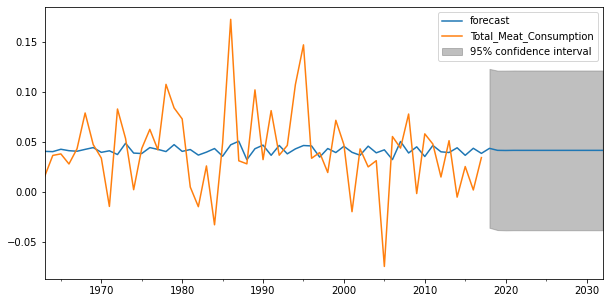

In [47]:
results_ARIMA.plot_predict(1,70)

In [48]:
ten_yr_forecast = results_ARIMA.predict(start=len(datasetLogDiffShifting),end = len(datasetLogDiffShifting) + 13 ) 

### Prediction & Reverse transformations of 13 year forecast

In [49]:
predictions_ARIMA_diff = pd.Series(ten_yr_forecast, copy=True)
predictions_ARIMA_diff.head()

2018-01-01    0.043457
2019-01-01    0.041462
2020-01-01    0.041345
2021-01-01    0.041458
2022-01-01    0.041445
Freq: AS-JAN, dtype: float64

In [50]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

2018-01-01    0.043457
2019-01-01    0.084919
2020-01-01    0.126263
2021-01-01    0.167721
2022-01-01    0.209167
Freq: AS-JAN, dtype: float64

In [51]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Total_Meat_Consumption in logscale'].iloc[-1], index=predictions_ARIMA_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

2018-01-01    23.799276
2019-01-01    23.840738
2020-01-01    23.882082
2021-01-01    23.923540
2022-01-01    23.964986
Freq: AS-JAN, dtype: float64

In [52]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction.head(5)

,0
2018-01-01,2.167176e+10
2019-01-01,2.258920e+10
2020-01-01,2.354272e+10
2021-01-01,2.453927e+10
2022-01-01,2.557768e+10


In [53]:
from google.colab import files
indexedDataset.to_csv('Brazil.csv')
reverted_back_prediction.to_csv('Brazil.csv', mode='a', header=False)

files.download('Brazil.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

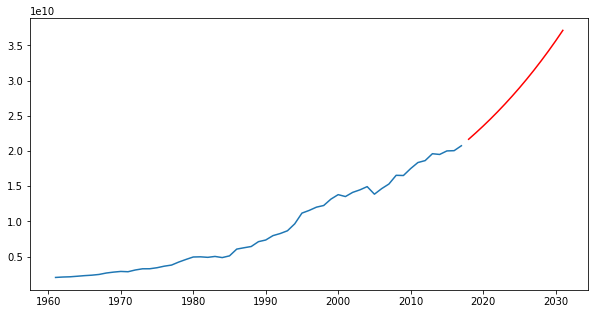

In [54]:
from matplotlib import pyplot
pyplot.plot(indexedDataset)

pyplot.plot(reverted_back_prediction, color='red')

#pyplot.show()

from google.colab import files
plt.savefig("Brazil.png")
files.download("Brazil.png") 

### 8. Using ARIMA for AR and MA  <a name = "ARIMA"></a>

Using ARIMA for making AR and MA models by setting the values of (p,d,q) as (2,1,0) and (0,1,2) respectively.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Plotting AR model


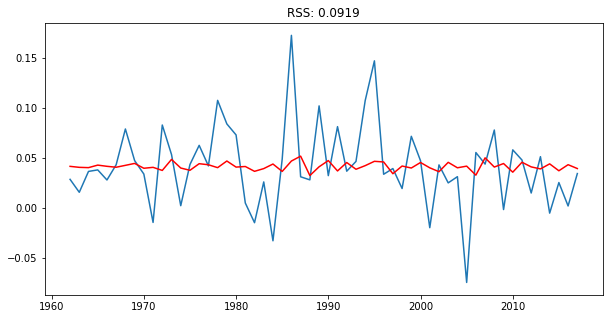

In [55]:
#AR Model
#making order = (2,1,0) gives RSS = 1.5023
 
from statsmodels.tsa.arima_model import ARIMA
model  =  ARIMA(indexedDataset_logScale, order = (2,1,0))
results_AR  =  model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Total_Meat_Consumption after log diff shifting'])**2))
print('Plotting AR model')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Plotting MA model


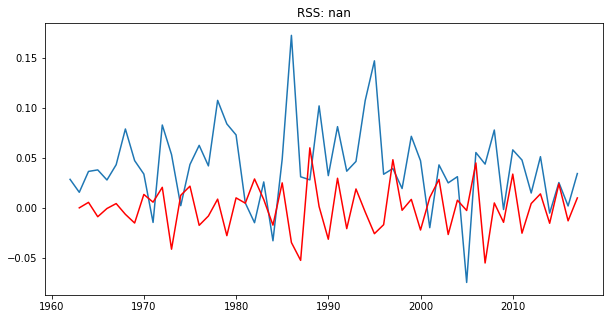

In [56]:
#MA Model
model  =  ARIMA(indexedDataset_logScale, order = (1,2,0))
results_MA  =  model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['Total_Meat_Consumption after log diff shifting'])**2))
print('Plotting MA model')

Note that, these models will give a value of RSS. Lower RSS values indicate a better model.